In [1]:
# Just the normal prequisites for using matplotlib and numpy in a Jupyter notebook
%matplotlib inline
# Use the svg backend, in my opinion it just makes better looking plots
%config InlineBackend.figure_format = 'svg'

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='INFO')

import os
import sys
from pathlib import Path
import IPython
from scipy import signal
import scipy.fftpack
from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Math import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import unittest

directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)

directory_path = Path(os.path.abspath('')).resolve()

![module](https://img.shields.io/badge/module-vca-yellow) ![status](https://img.shields.io/badge/status-work%20in%20progress-orange)

## *freqdoubler*

<a href="https://photos.app.goo.gl/pg6iZUC32rTKX5LC7"><img src="https://spielhuus.github.io/elektrophon/images/kontrast-logo-tmb.jpg" height="300px" align="right"></a>

***table of contents***

* [*about*](#about)
* [*construction*](#construction)
* [*calibration*](#calibration)
* [*usage*](#usage)
* [*credits*](#credits)
* [*links*](#links)
* [*changelog*](#changelog)
  
<br/><br/><br/><br/>

## *about*


### *frequency doubler*

In [2]:
#load the diffpair schema
kicad_netlist_path = directory_path.joinpath('main', 'main.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

In [3]:
#simulate interpolating scanner
doubler = parser.build_circuit(ground=5)
doubler.include(spice_library['TL072'])
doubler.include(spice_library['TL072c'])
#doubler.include(spice_library['LT1014x_30V'])
#doubler.include(spice_library['BC556B'])
#doubler.include(spice_library['BC857CW'])
#doubler.include(spice_library['LM13700/NS'])
#doubler.include(spice_library['LM13700d'])
#doubler.include(spice_library['D1N4148'])
doubler.V('1', '+15V', doubler.gnd, 'DC 15')
doubler.V('2', '-15V', doubler.gnd, 'DC -15')
doubler.V('3', 'SAW_IN', doubler.gnd, 'DC 5V AC 5V PULSE(-5 5 0 10m 0 1u 10m)')
#doubler.V('4', 'IN_2', doubler.gnd, 'DC 5V AC 5V SIN(0 5 800)')
#doubler.V('5', 'IN_3', doubler.gnd, 'DC 5V AC 5V SIN(0 5 1200)')
#doubler.V('6', 'IN_4', doubler.gnd, 'DC 5V AC 5V SIN(0 5 1600)')
#doubler.V('7', 'CV_IN', doubler.gnd, 'DC 5V AC 5V PULSE(0 5 0 30m 0 1u 30m)') 

simulator = doubler.simulator(temperature=25, nominal_temperature=25)
analysis_doubler = simulator.transient(step_time=1@u_us, end_time=40@u_ms)

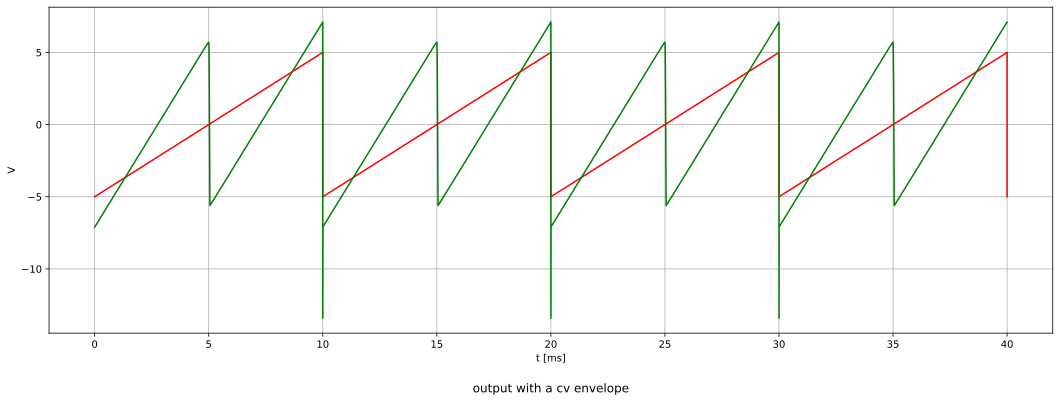

In [4]:
#plot the results
fig, ax0 = plt.subplots(figsize=(18, 6))

#plot cv
ax0.plot(u_ms(analysis_doubler['SAW_IN'].abscissa), analysis_doubler['SAW_IN'], c='Red')
ax0.plot(u_ms(analysis_doubler['OUT'].abscissa), analysis_doubler['OUT'], c='Green')

ax0.grid()
ax0.set_xlabel('t [ms]')
ax0.set_ylabel('V')
ax0.set_title('output with a cv envelope', y=-0.2)

plt.show()


with a sine input

In [5]:
#simulate interpolating scanner
doubler = parser.build_circuit(ground=5)
doubler.include(spice_library['TL072'])
doubler.include(spice_library['TL072c'])
doubler.V('1', '+15V', doubler.gnd, 'DC 15')
doubler.V('2', '-15V', doubler.gnd, 'DC -15')
doubler.V('6', 'SAW_IN', doubler.gnd, 'DC 5V AC 5V SIN(0 5 100)')

simulator = doubler.simulator(temperature=25, nominal_temperature=25)
analysis_doubler = simulator.transient(step_time=1@u_us, end_time=40@u_ms)

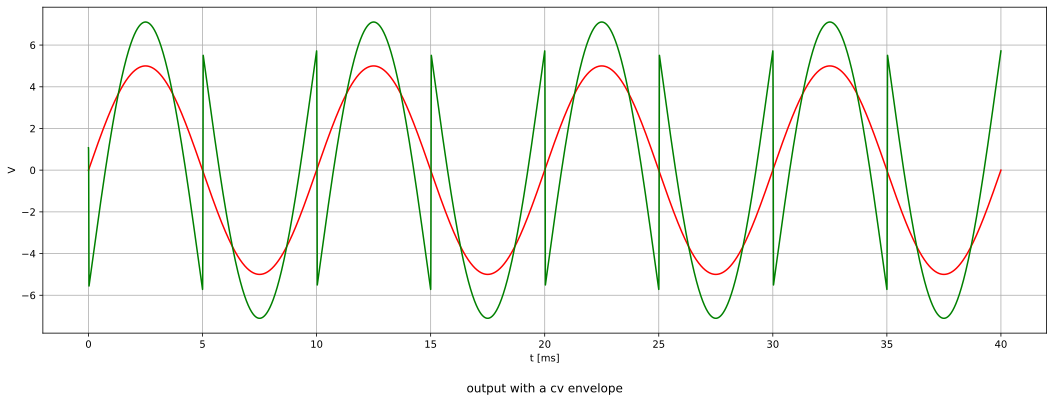

In [6]:
#plot the results
fig, ax0 = plt.subplots(figsize=(18, 6))

#plot cv
ax0.plot(u_ms(analysis_doubler['SAW_IN'].abscissa), analysis_doubler['SAW_IN'], c='Red')
ax0.plot(u_ms(analysis_doubler['OUT'].abscissa), analysis_doubler['OUT'], c='Green')

ax0.grid()
ax0.set_xlabel('t [ms]')
ax0.set_ylabel('V')
ax0.set_title('output with a cv envelope', y=-0.2)

plt.show()

### *frequency shifter*

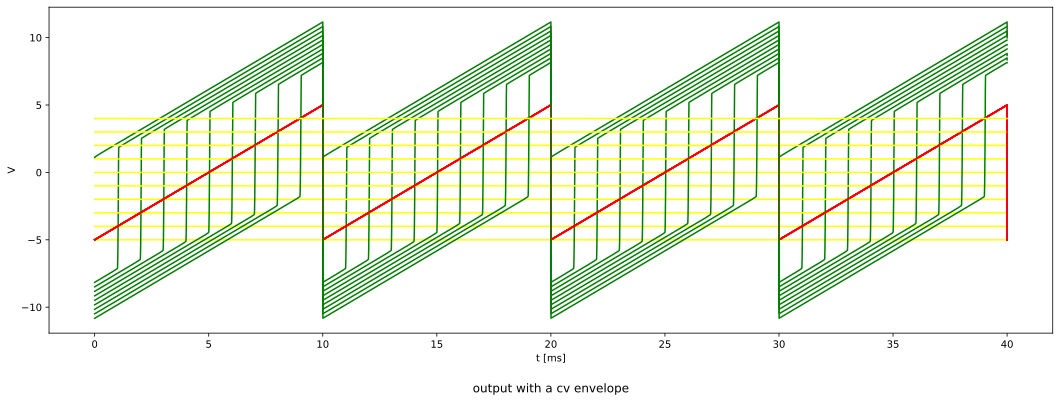

In [7]:
#load frequency shifter schema
kicad_netlist_path = directory_path.joinpath('shifter', 'shifter.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

#plot the results
fig, ax0 = plt.subplots(figsize=(18, 6))

for shift in np.arange(-5, 5, 1) :
    #simulate 
    shifter = parser.build_circuit(ground=5)
    shifter.include(spice_library['TL072'])
    shifter.include(spice_library['TL072c'])
    shifter.V('1', '+15V', shifter.gnd, 'DC 15')
    shifter.V('2', '-15V', shifter.gnd, 'DC -15')
    shifter.V('3', 'SAW_IN', shifter.gnd, 'DC 5V AC 5V PULSE(-5 5 0 10m 0 1u 10m)')
    shifter.V('4', 'PHASE_SHIFT', shifter.gnd, '%dV' % shift) #'DC 5V AC 5V PULSE(-5 5 0 10m 0 1u 10m)')

    simulator = shifter.simulator(temperature=25, nominal_temperature=25)
    analysis_shifter = simulator.transient(step_time=1@u_us, end_time=40@u_ms)

    #plot cv
    ax0.plot(u_ms(analysis_shifter['SAW_IN'].abscissa), analysis_shifter['SAW_IN'], c='Red')
    ax0.plot(u_ms(analysis_shifter['OUT'].abscissa), analysis_shifter['OUT'], c='Green')
    ax0.plot(u_ms(analysis_shifter['PHASE_SHIFT'].abscissa), analysis_shifter['PHASE_SHIFT'], c='Yellow')

    ax0.grid()
    ax0.set_xlabel('t [ms]')
    ax0.set_ylabel('V')
    ax0.set_title('output with a cv envelope', y=-0.2)

plt.show()



shifter with two sines

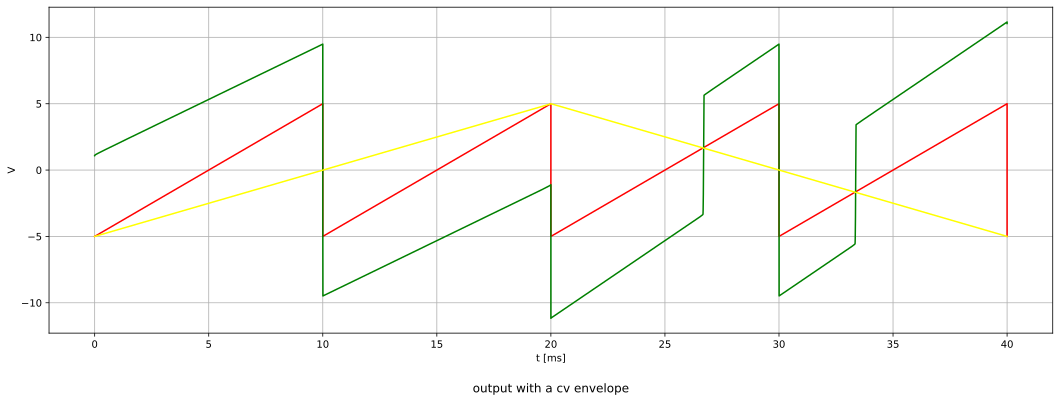

In [8]:
#load frequency shifter schema
kicad_netlist_path = directory_path.joinpath('shifter', 'shifter.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

#plot the results
fig, ax0 = plt.subplots(figsize=(18, 6))

#simulate 
shifter = parser.build_circuit(ground=5)
shifter.include(spice_library['TL072'])
shifter.include(spice_library['TL072c'])
shifter.V('1', '+15V', shifter.gnd, 'DC 15')
shifter.V('2', '-15V', shifter.gnd, 'DC -15')
shifter.V('3', 'SAW_IN', doubler.gnd, 'DC 5V AC 5V PULSE(-5 5 0 10m 0 1u 10m)')
shifter.V('4', 'PHASE_SHIFT', doubler.gnd, 'DC 5V AC 5V PULSE(-5 5 0 20m 20m 1u 40m)')

simulator = shifter.simulator(temperature=25, nominal_temperature=25)
analysis_shifter = simulator.transient(step_time=1@u_us, end_time=40@u_ms)

#plot cv
ax0.plot(u_ms(analysis_shifter['SAW_IN'].abscissa), analysis_shifter['SAW_IN'], c='Red')
ax0.plot(u_ms(analysis_shifter['OUT'].abscissa), analysis_shifter['OUT'], c='Green')
ax0.plot(u_ms(analysis_shifter['PHASE_SHIFT'].abscissa), analysis_shifter['PHASE_SHIFT'], c='Yellow')

ax0.grid()
ax0.set_xlabel('t [ms]')
ax0.set_ylabel('V')
ax0.set_title('output with a cv envelope', y=-0.2)

plt.show()

fast modulator

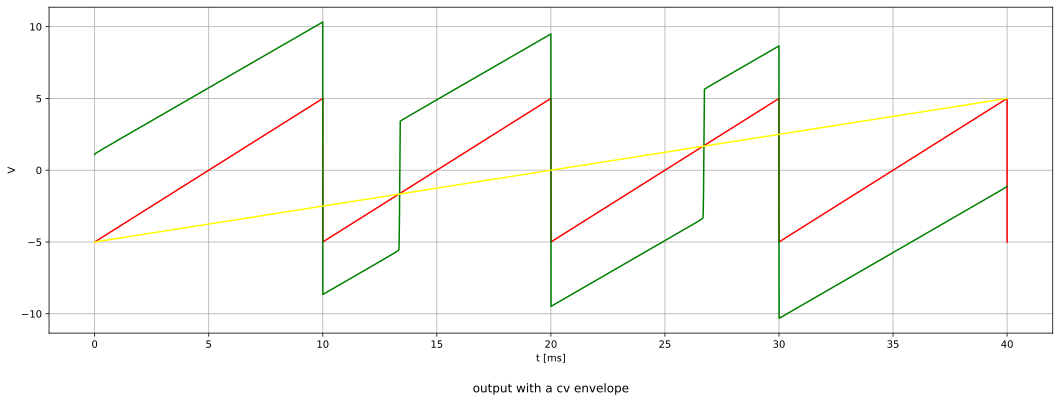

In [9]:
#load frequency shifter schema
kicad_netlist_path = directory_path.joinpath('shifter', 'shifter.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

#plot the results
fig, ax0 = plt.subplots(figsize=(18, 6))

#simulate 
shifter = parser.build_circuit(ground=5)
shifter.include(spice_library['TL072'])
shifter.include(spice_library['TL072c'])
shifter.V('1', '+15V', shifter.gnd, 'DC 15')
shifter.V('2', '-15V', shifter.gnd, 'DC -15')
shifter.V('3', 'SAW_IN', shifter.gnd, 'DC 5V AC 5V PULSE(-5 5 0 10m 0 1u 10m)')
shifter.V('4', 'PHASE_SHIFT', shifter.gnd, 'DC 5V AC 5V PULSE(-5 5 0 40m 0 1u 40m)')

simulator = shifter.simulator(temperature=25, nominal_temperature=25)
analysis_shifter = simulator.transient(step_time=1@u_us, end_time=40@u_ms)

#plot cv
ax0.plot(u_ms(analysis_shifter['SAW_IN'].abscissa), analysis_shifter['SAW_IN'], c='Red')
ax0.plot(u_ms(analysis_shifter['OUT'].abscissa), analysis_shifter['OUT'], c='Green')
ax0.plot(u_ms(analysis_shifter['PHASE_SHIFT'].abscissa), analysis_shifter['PHASE_SHIFT'], c='Yellow')

ax0.grid()
ax0.set_xlabel('t [ms]')
ax0.set_ylabel('V')
ax0.set_title('output with a cv envelope', y=-0.2)

plt.show()

In [10]:
class VoltageDivider(SubCircuitFactory):
    __name__ = 'voltage_divider'
    __nodes__ = ('n1', 'n2', 'n3' )
    def __init__(self, R=100@u_kΩ, w=0.4):
        super().__init__()
        self.R(1, 'n1', 'n2', R * w)
        self.R(2, 'n2', 'n3', R * (1.0-w) )

#load frequency shifter schema
kicad_netlist_path = directory_path.joinpath('shifter', 'shifter_sine.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

#plot the results
fig, ax0 = plt.subplots(figsize=(18, 6))

#simulate 
shifter = parser.build_circuit(ground=5)
shifter.include(spice_library['TL072'])
shifter.include(spice_library['TL072c'])
shifter.include(spice_library['BC846B'])

shifter.V('1', '+15V', shifter.gnd, 'DC 15')
shifter.V('2', '-15V', shifter.gnd, 'DC -15')
shifter.V('3', 'SAW_IN', shifter.gnd, 'DC 5V AC 5V PULSE(-5 5 0 10m 0 1u 10m)')
shifter.V('4', 'PHASE_SHIFT', shifter.gnd, 'DC 5V AC 5V PULSE(-5 5 0 40m 0 1u 40m)')
shifter.subcircuit(VoltageDivider(R=50@u_kΩ,w=0.5))

simulator = shifter.simulator(temperature=25, nominal_temperature=25)
analysis_shifter = simulator.transient(step_time=1@u_us, end_time=40@u_ms)

#plot cv
ax0.plot(u_ms(analysis_shifter['SAW_IN'].abscissa), analysis_shifter['SAW_IN'], c='Red')
ax0.plot(u_ms(analysis_shifter['SINE_OUT'].abscissa), analysis_shifter['SINE_OUT'], c='Green')
ax0.plot(u_ms(analysis_shifter['PHASE_SHIFT'].abscissa), analysis_shifter['PHASE_SHIFT'], c='Yellow')

ax0.grid()
ax0.set_xlabel('t [ms]')
ax0.set_ylabel('V')
ax0.set_title('output with a cv envelope', y=-0.2)

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\etien\\elektrophon\\modules\\freqdoubler\\shifter\\shifter_sine.cir'

## *construction*

for the final circuit input and output buffering and biasing is needed. the buffering is done with opamps. 


first we design the input stage. the input voltage for the X signal should be 10mV and 20mV for the control voltage.


## *references*

- [Magnus Synth Schematics][5] Magnus Danielson sawtooth doubler and phase shifter

[1]: https://www.youtube.com/watch?v=3jlsDhgQJOM
[2]: http://www.till.com/articles/wavepalette/
[3]: https://web.archive.org/web/20190516064813/https://rubidium.dyndns.org/~magnus/synths/schematics/sawphaseshift2.pdf
[4]: https://electro-music.com/forum/viewtopic.php?highlight=vca+morph&t=58189
[5]: https://web.archive.org/web/20140830210313/http://home.swipnet.se/cfmd/synths/schematics/
[6]: http://electronotes.netfirms.com/EN228.pdf
[7]: http://electronotes.netfirms.com/AN73.pdf




In [ ]:
unittest.main(argv=[''], verbosity=2, exit=False)